### Install

In [1]:
!apt-get install libglib2.0-0 -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libglib2.0-0 is already the newest version (2.56.4-0ubuntu0.18.04.9).
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


### GlioMT Network

In [1]:
import torch
from src.models.xai.multimodal_vit_xai import vit_base_patch16_224

# Model
net = vit_base_patch16_224(pretrained=True, pretrained_cfg="augreg_in21k_ft_in1k", pretrained_strict=False, in_chans=4, num_classes=1)        
net = net.cuda()

# Load checkpoint
checkpoint = torch.load('/home/user/GlioMT/sample/checkpoint_best_auc.pth')
net.load_state_dict(checkpoint['net'])

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


<All keys matched successfully>

### Data Load

In [18]:
import SimpleITK as sitk
import numpy as np

# Set Data Directory
data_dir = '/home/user/GlioMT/sample/UCSF-PDGM-0251/'
annoy_id = 'UCSF-PDGM-0251'


def normalize_images(t1, t1c, t2, flair):
    t1 = (t1 - t1.mean()) / max(t1.std(), 1e-8)
    t1c = (t1c - t1c.mean()) / max(t1c.std(), 1e-8)
    t2 = (t2 - t2.mean()) / max(t2.std(), 1e-8)
    flair = (flair - flair.mean()) / max(flair.std(), 1e-8)
    
    return t1, t1c, t2, flair

# Whole image
img_t1 = sitk.GetArrayFromImage(sitk.ReadImage(data_dir + annoy_id + '_T1.nii.gz'))
img_t1ce = sitk.GetArrayFromImage(sitk.ReadImage(data_dir + annoy_id + '_T1C.nii.gz'))
img_t2 = sitk.GetArrayFromImage(sitk.ReadImage(data_dir + annoy_id + '_T2.nii.gz'))
img_flair = sitk.GetArrayFromImage(sitk.ReadImage(data_dir + annoy_id + '_FLAIR.nii.gz'))


# Image Preprocessing
img_t1, img_t1ce, img_t2, img_flair = normalize_images(img_t1, img_t1ce, img_t2, img_flair)
img = np.stack([img_t1, img_t1ce, img_t2, img_flair], axis=0)
img = torch.from_numpy(img).float().cuda()
print('Whole Image Shape: ', img.shape)

# seg
seg = sitk.GetArrayFromImage(sitk.ReadImage(data_dir + annoy_id + '_seg.nii.gz'))
seg[seg !=0] = 1
z_seg = seg.sum(-1).sum(-1)
max_roi_idx = np.argmax(z_seg)

# Max ROI Image
max_roi_img_2d = img[:, max_roi_idx]
print('Max ROI Image Shape: ', max_roi_img_2d.shape)


Whole Image Shape:  torch.Size([4, 138, 177, 128])
Max ROI Image Shape:  torch.Size([4, 177, 128])


In [19]:
# Transform
from monai.transforms import Compose, Resize, ToTensor
        
test_transform = Compose([
                        Resize(spatial_size=(224, 224), mode="bicubic"),
                        ToTensor()
                        ])

input_img = test_transform(max_roi_img_2d)
input_img = input_img.unsqueeze(0).cuda()
print('Input Image Shape: ', input_img.shape)

Input Image Shape:  torch.Size([1, 4, 224, 224])


In [22]:
# Clinical Features
# clinical_feats = [['50'], ['male']] # age, sex
clinical_feats = [['36'], ['male']] # age, sex

### Forward

In [33]:
import torch.nn.functional as F
outputs = net(input_img, clinical_feats)
print('Probability: ', F.sigmoid(outputs).item())

Probability:  0.9931446313858032


In [36]:
# Define Attribution Generator
from src.models.xai.xai_methods import GenerateViTClinicalAttMap

AttriGen = GenerateViTClinicalAttMap()

# Generate Attribution Map & Modality Contribution Score
attmap_max_prob = AttriGen.generate_attribution(net, input_img, clinical_feats, 0)


### Modality Contribution Score

In [37]:
max_roi_relevance_score = AttriGen.return_relevance_score(net)
print(attmap_max_prob.shape)
print('Image Contribution Score: ', round(max_roi_relevance_score[0] *100, 2), '%')
print('Age Contribution Score: ', round(max_roi_relevance_score[1] *100, 2), '%')
print('Sex Contribution Score: ', round(max_roi_relevance_score[2] *100, 2), '%')


(224, 224)
Image Contribution Score:  94.49 %
Age Contribution Score:  2.72 %
Sex Contribution Score:  2.79 %


### Plot

In [38]:
seg_2d = seg[max_roi_idx:max_roi_idx+1]
seg_2d = test_transform(seg_2d)
seg_2d = seg_2d.unsqueeze(0).cuda()
print('Seg mask Shape: ', seg_2d.shape)

Seg mask Shape:  torch.Size([1, 1, 224, 224])


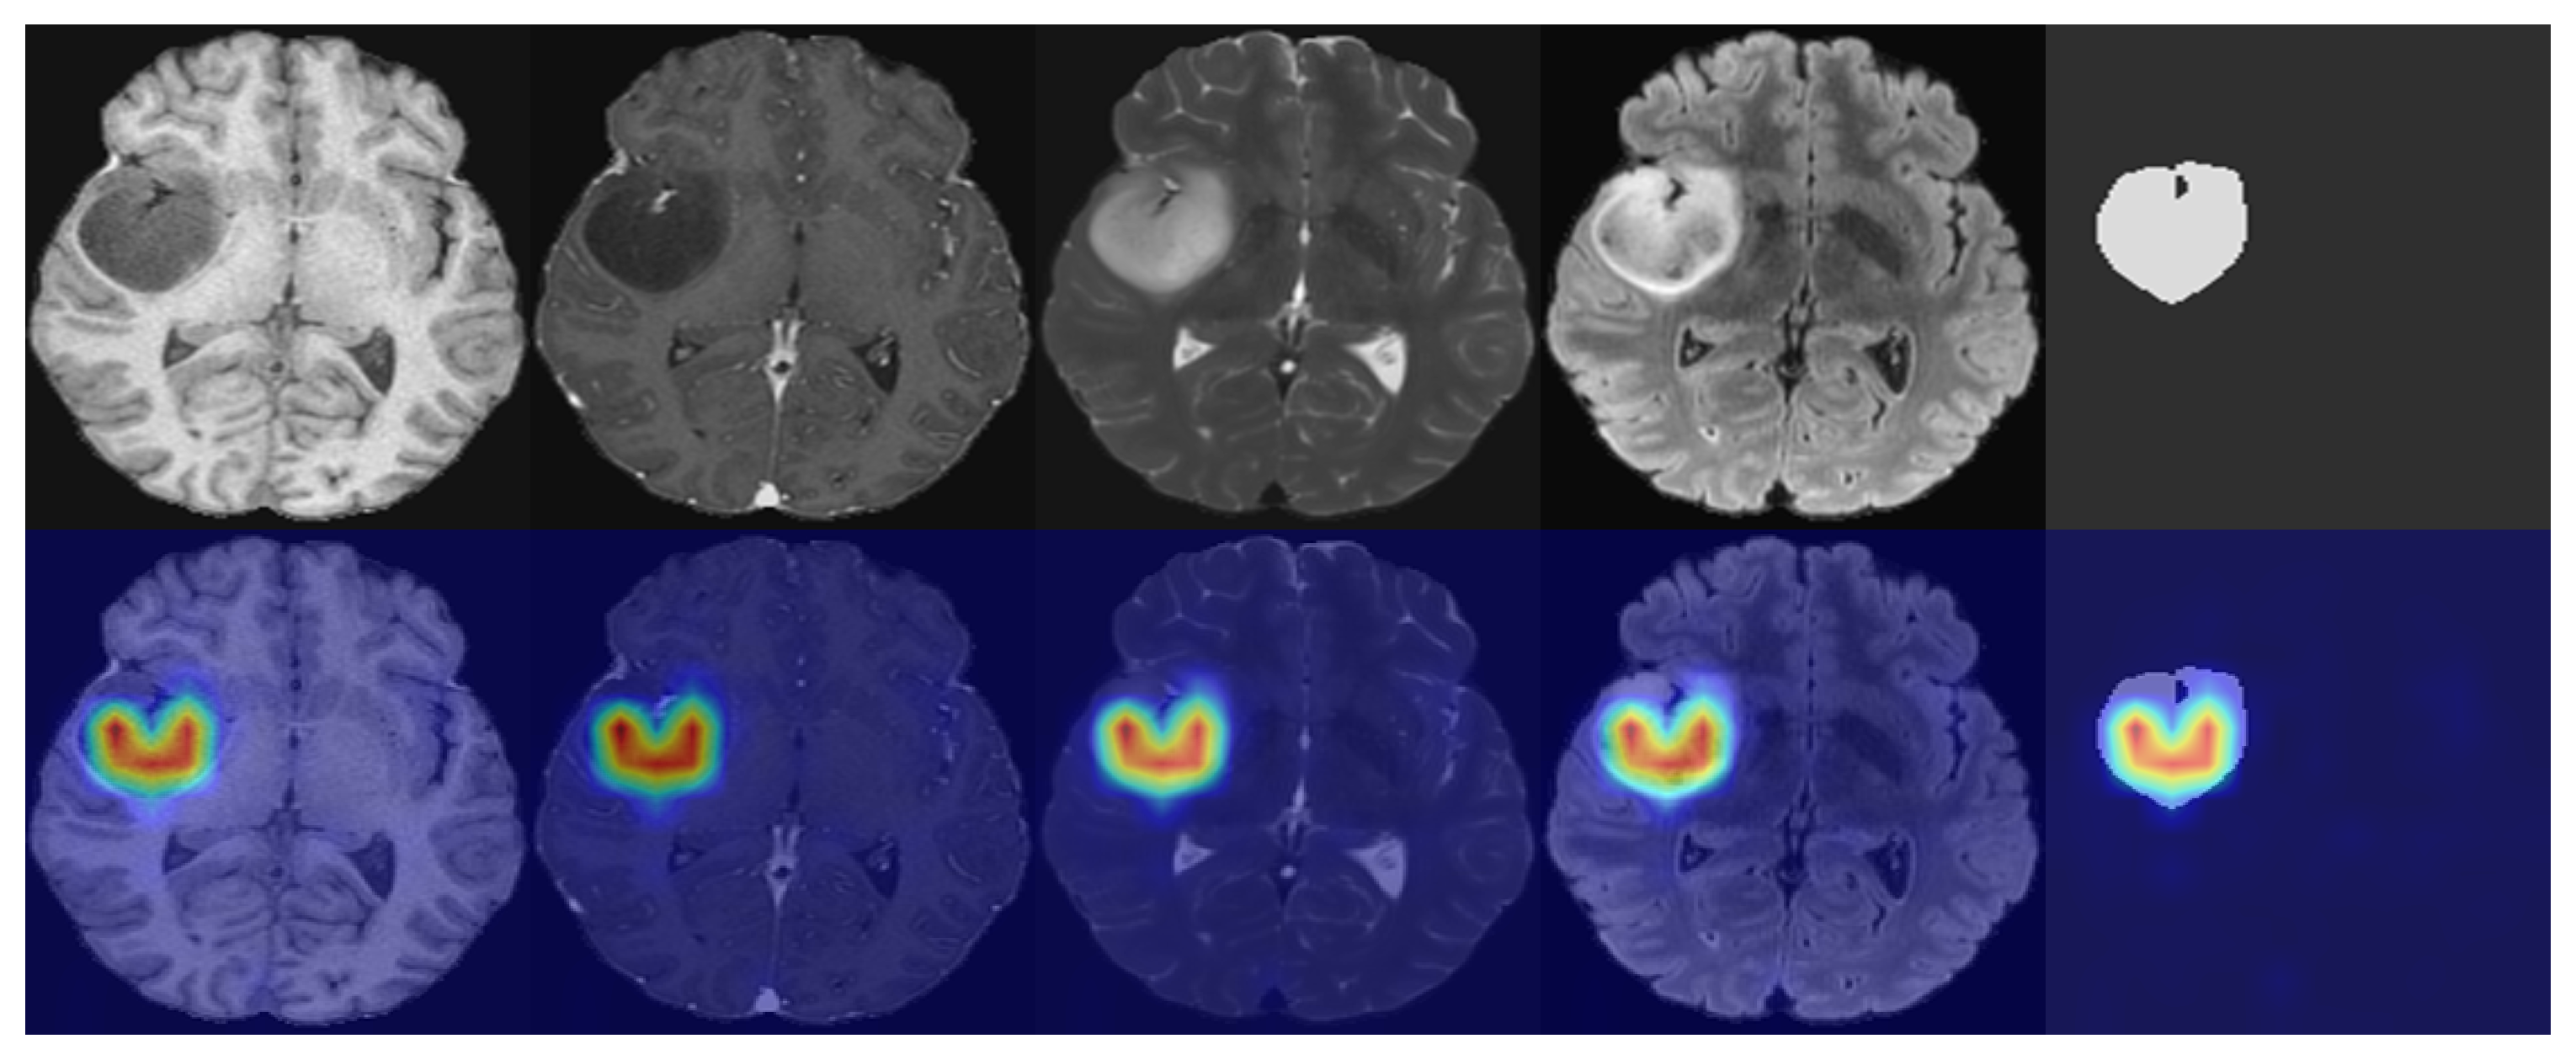

In [39]:
import matplotlib.pyplot as plt
import os


def minmax_norm(img):
    img = (img - img.min()) / (img.max() - img.min())
    return img

def plot_and_save(inputs, seg, cam_img=None):
    # Plot T2 Image, B, C, H, W
    all_image = inputs.permute(1, 2, 3, 0).data.cpu().numpy() # C, H, W, 1
    seg_slice = seg.permute(1, 2, 3, 0).data.cpu().numpy()
    all_image = np.concatenate((all_image, seg_slice), axis=0) # C x H x W x 1

    fig = plt.figure(figsize=(10, 4), dpi=300)
    # 전체 figure의 크기를 조절하여 subplot 간격을 자연스럽게 조절
    gs = fig.add_gridspec(2, 5, wspace=0, hspace=0)
    
    for i in range(5):
        # First row
        ax = fig.add_subplot(gs[0,i])
        ax.imshow(minmax_norm(all_image[i]), cmap=plt.cm.gray, interpolation='bilinear')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

        # Second row
        ax = fig.add_subplot(gs[1,i])
        ax.imshow(minmax_norm(all_image[i]), cmap=plt.cm.gray, interpolation='nearest')
        ax.imshow(cam_img, cmap=plt.cm.jet, alpha=.5, interpolation='bilinear')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)



    plt.tight_layout()
    plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1)
    plt.show()


plot_and_save(input_img, seg_2d, attmap_max_prob)

